# Titanic Dataset: Predicting Survival <br>

# What is the big picture?
<br>

- I am given the data of passengers on the historical ship, the Titanic. My goal is to predict whether the passenger survived or not based on features like age, gender, class, etc.

- This is a learning/for-fun project and I just want to have high accuracy when predicting on the test set.

- This is a supervised-learning problem because I am given the target labels for the training set - whether they survived or not. 

- This is also a binary classification problem because the target feature can be one of two categories - negative (dead) and positive (survived). 

- I will be using batch or offline learning because the dataset cannot be updated (it's like 100 years old after all) and the dataset is not large. 

- I will also be using model-based learning because I have not learned instance-based learning yet.

- The performance measure is accuracy. I don't have to consider precision-recall tradeoff because I just want to be as accurate as possible.

# Setup
<br>

In [230]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the models and scores
import joblib
PROJECT_ROOT_DIR = "."
PROJECT_ID = "titanic"
MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "_models", PROJECT_ID)
os.makedirs(MODELS_PATH, exist_ok=True)

# Save models, cross-val accuracy scores, cross-val predictions, and pipelines
def save_model(model, model_id):
    path = os.path.join(MODELS_PATH, model_id + ".pkl")
    print("Saving model", model_id)
    joblib.dump(model, path)

def load_model(model_id):
    path = os.path.join(MODELS_PATH, model_id + ".pkl")
    return joblib.load(path)

# Get Data
<br>
<br>

In [304]:
import pandas as pd

TITANIC_PATH = os.path.join(PROJECT_ROOT_DIR, "_datasets", PROJECT_ID)

def load_data(titanic_path=TITANIC_PATH):
    train = pd.read_csv(os.path.join(titanic_path, "train.csv"))
    test = pd.read_csv(os.path.join(titanic_path, "test.csv"))
    example = pd.read_csv(os.path.join(titanic_path, "gender_submission.csv"))
    return train, test, example

In [305]:
train, test, example_submission = load_data()

- Don't touch the test set till we've finalized our model

In [233]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Missing Values
<br>

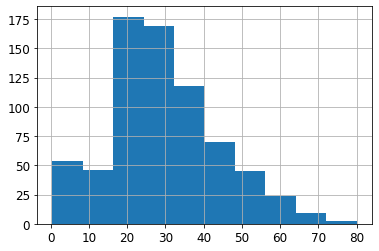

In [234]:
missing_features = ['Age', 'Cabin', 'Embarked']

train['Age'].hist()
plt.show()

- This has a right-skewed distribution
    - we may want to use 'median' as the imputing strategy

In [235]:
train['Cabin'].isna().sum()

687

- too many missing values

In [236]:
train['Embarked'].isna().sum()

2

- we can impute with most_freq

# Categorical Attributes
<br>

Get distribution for categorical data. *Just because a feature is non-numerical doesn't mean it's categorical.*

In [237]:
train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [238]:
train["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [239]:
train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [240]:
def extract_title_name(s):
    period = s.index('.')
    
    title = ""
    c = ""
    while(1):
        period -= 1
        c = s[period]
        if c == " ":
            break
        title = c + title
    
    return title

train["Title"] = train["Name"].apply(extract_title_name)

<AxesSubplot:xlabel='Title', ylabel='count'>

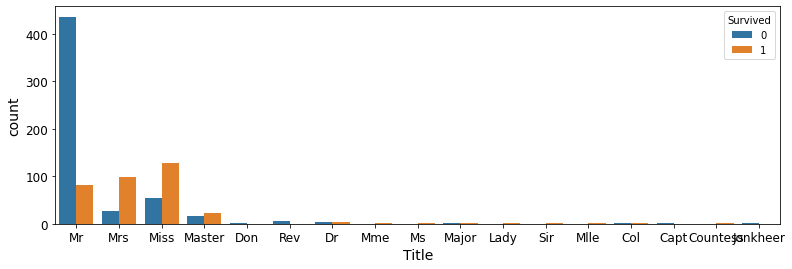

In [241]:
import seaborn as sns

plt.figure(figsize=(13,4))
sns.countplot(x="Title", hue="Survived", data=train)

- Wow! There's definitely some correlation here - **Mr** has a very uneven distribution and a majority did not survive while **Mrs** and **Miss** has a majority surviving!
    - But be careful, because this is closely related to the **Sex** feature

In [242]:
train["Title"].value_counts(normalize=True)

Mr          0.580247
Miss        0.204265
Mrs         0.140292
Master      0.044893
Dr          0.007856
Rev         0.006734
Mlle        0.002245
Major       0.002245
Col         0.002245
Countess    0.001122
Capt        0.001122
Ms          0.001122
Sir         0.001122
Lady        0.001122
Mme         0.001122
Don         0.001122
Jonkheer    0.001122
Name: Title, dtype: float64

- **Ms** can be merged with **Miss** and **Sir** can be merged with **Mr**
- **Miss** and **Mrs** can be merged into **Mrs**
- Everything else can be merged into **Noble**
- So the final categories should be **Mr**, **Mrs**, **Noble**

In [243]:
def group_titles(t):
    if (t == "Ms") or (t == "Miss") or (t == "Mrs"):
        return "Mrs"
    elif (t == "Sir") or (t == "Mr"):
        return "Mr"
    else:
        return "Noble"

train["Title"] = train["Title"].apply(group_titles)
train["Title"].value_counts(normalize=True)

Mr       0.581369
Mrs      0.345679
Noble    0.072952
Name: Title, dtype: float64

<AxesSubplot:xlabel='Title', ylabel='count'>

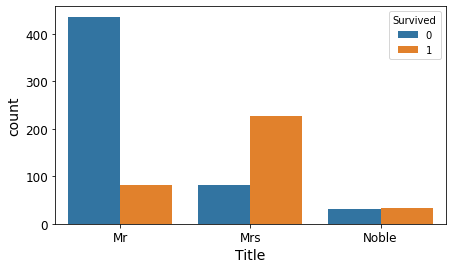

In [244]:
plt.figure(figsize=(7,4))
sns.countplot(x="Title", hue="Survived", data=train)

In [245]:
train.drop("Title", axis=1, inplace=True)

- Drop this for now, **Title** can be included as a test in our future pipelines

In [246]:
train["Ticket"].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

- Noticed some tickets with a location in front, I wonder if this is a redundant feature since **Embarked** exists?

In [247]:
test_ticket = "CA. 2343"
test_ticket.split(' ')[0]

'CA.'

In [248]:
def extract_acronym_ticket(s):
    if s[0].isdigit():
        return "NaN"
    return s.split(' ')[0]

train["Ticket_loc"] = train["Ticket"].apply(extract_acronym_ticket)

In [249]:
train["Ticket_loc"].value_counts()[:5]

NaN       661
PC         60
C.A.       27
STON/O     12
A/5        10
Name: Ticket_loc, dtype: int64

- Most of the tickets do not have a location, so using this as a feature is unwise unless I can somehow impute or give meaning to tickets with no prefix

In [250]:
train.drop("Ticket_loc", axis=1, inplace=True)

In [251]:
train["Cabin"].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

- An interesting patten is the letter before the Cabin - this could mean deck and would probably have some correlation with our target

In [252]:
train["Cabin"].apply(lambda s: str(s))

0       nan
1       C85
2       nan
3      C123
4       nan
       ... 
886     nan
887     B42
888     nan
889    C148
890     nan
Name: Cabin, Length: 891, dtype: object

- If I do use this feature I would have to impute the missing values since dropping them would mean losing a huge portion of my training data which is unacceptable

In [253]:
def extract_cabin_letter(s):
    return str(s)[0]

train["Letter"] = train["Cabin"].apply(extract_cabin_letter)

In [254]:
train["Letter"].value_counts()

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Letter, dtype: int64

- The nan occupies too large a portion, I will plot the correlation with Survived but even if there is correlation this feature will not be used since it's missing too much data

<AxesSubplot:xlabel='Letter', ylabel='count'>

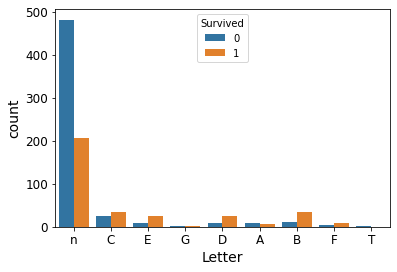

In [255]:
sns.countplot(x="Letter", hue="Survived", data=train)

- I can see that for the few non-missing features, a majority of **B** cabin people survived. It's really a pity that the cabin data was not preserved, otherwise I believe this will be a very strong feature

In [256]:
train.drop("Letter", axis=1, inplace=True)

# Correlation of Numerical Features
<br>

In [257]:
# Use train because we want to see correlation with target feature - Survived
corr_matrix = train.corr()

corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

- **Fare** has a rather high positive correlation, which makes sense since people who payed more were probably richer and had more priority than poorer people
- **Parch** also has some positive correlation, but I will need to graph the distribution on a scatterplot to further understand the data
- **PassengerId** has no significant correlation and that is also pretty intuitive, so this feature can be dropped
- **SibSp** has some negative correlation, but it might be redundant since Parch exists
- **Age** has some negative correlation, but there were also far less older people - the distribution was skewed right - so this can be further validated if we applied a log to Age
- **Pclass** has a direct negative correlation and is the most correlated with the target feature, (note that class is 1 for rich people and 3 for poor people in the order of 1, 2, 3)
    - this makes sense since 3rd class would be farther from safety both in terms of location and priority

Let's explicitly set `PassengerId` as the index

In [258]:
train = train.set_index("PassengerId")
test = test.set_index("PassengerId")

# Pipeline
- For numerical attributes: impute median, std scaler
- For categorical attributes: imputer most freq, 1hot encoding
- Unlisted attributes are automatically dropped

In [259]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_attr = ["Age", "Fare", "Parch", "SibSp"]

cat_attr = ["Sex", "Pclass", "Embarked"]

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse=False)),
])

preparation_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attr),
    ("cat", cat_pipeline, cat_attr),
])

In [260]:
X_train = preparation_pipeline.fit_transform(train)

- the columntransformer automatically drops the remaining attributes

In [261]:
X_train

array([[-0.56573646, -0.50244517, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.78684529, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.48885426, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 , -0.17626324,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.04438104, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.49237783, -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [262]:
y_train = train["Survived"]

***
We want to move as fast as possible after getting a basic grasp of the data! This is because we want to first build a working pipeline and model that is <u><b>good enough</b></u>.
<br>
<br>
Once we have a working model and pipeline then we can analyze the errors and gain insights from the model itself! This beats grinding for hours on training data and getting your head fuzzy with all the things you have to remember. 
<br>
<br>
And once you do gain any insights and decide to create new features, drop current ones, try different models, fine-tune, etc. you will find that it is extremely quick and easy to implement! You only have to add to the current framework instead of struggling with a massive and messy project!
***

# Models
<br>

In [353]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [354]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train,
                                scoring="accuracy", cv=10)

In [355]:
forest_scores.mean()

0.8093008739076154

In [356]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")

In [357]:
svc_scores = cross_val_score(svm_clf, X_train, y_train,
                             scoring="accuracy", cv=10)

In [358]:
svc_scores.mean()

0.8249313358302123

- more linear is better? let's try logreg

In [359]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

In [360]:
log_scores = cross_val_score(log_reg, X_train, y_train,
                             scoring="accuracy", cv=10)

In [361]:
log_scores.mean()

0.7991260923845193

- Our training data is quite small, so cross-validation won't be as effective
<br>
</br>
Let's go with <b>svm_clf</b>

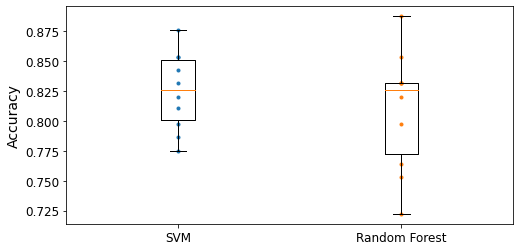

In [362]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svc_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svc_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

- As we can see, Random Forest has higher max score and a wider spread - which means SVM will probably generalize better

# Fine-Tuning
<br>

In [272]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_dist = {
    "C": uniform(2, 10),
    "gamma": uniform(0.1, 1)
}

rand_search = RandomizedSearchCV(svm_clf, param_distributions=param_dist, 
                                n_iter=100, cv=10, scoring="accuracy",
                                verbose=1, random_state=42)

In [273]:
# rand_search.fit(X_train, y_train)

In [274]:
# save_model(rand_search.best_estimator_, "svm_clf_model")

In [275]:
svm_clf = load_model("svm_clf_model")

# Feature Engineering
<br>

In [276]:
train["AgeBucket"] = train["Age"] // 15 * 15
train[["AgeBucket", "Survived"]].groupby(by="AgeBucket").mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [277]:
train["Relatives"] = train["Parch"] + train["SibSp"]
train[["Relatives", "Survived"]].groupby(by="Relatives").mean()

,Survived
Relatives,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


- Not sure how this would affect the predictor, there may be a chance of overfitting the training set

In [278]:
exp_data = train.copy()
exp_data["Name"] = train["Name"].str.split()
exp_data["Name"]

PassengerId
1                           [Braund,, Mr., Owen, Harris]
2      [Cumings,, Mrs., John, Bradley, (Florence, Bri...
3                             [Heikkinen,, Miss., Laina]
4      [Futrelle,, Mrs., Jacques, Heath, (Lily, May, ...
5                          [Allen,, Mr., William, Henry]
                             ...                        
887                            [Montvila,, Rev., Juozas]
888                    [Graham,, Miss., Margaret, Edith]
889       [Johnston,, Miss., Catherine, Helen, "Carrie"]
890                           [Behr,, Mr., Karl, Howell]
891                              [Dooley,, Mr., Patrick]
Name: Name, Length: 891, dtype: object

In [279]:
mr_titles = ["Mr.", "Sir."]
mrs_titles = ["Miss.", "Mrs.", "Ms.", "Lady.", "Mme."]

def get_title(names):
    titles = []
    
    for l in names:
        for s in l:
            if '.' in s:
                if s in mr_titles:
                    titles.append("Mr")
                    break
                elif s in mrs_titles:
                    titles.append("Mrs")
                    break
                else:
                    titles.append("Noble")
                    break
    return titles

exp_data["Title"] = get_title(exp_data["Name"])
exp_data["Title"].value_counts()

Mr       518
Mrs      310
Noble     63
Name: Title, dtype: int64

In [280]:
exp_data[["Title", "Survived"]].groupby(by="Title").mean()

,Survived
Title,
Mr,0.158301
Mrs,0.738710
Noble,0.492063


- hehehe...we might've got ourselves a great feature...hehehe

In [281]:
from sklearn.base import BaseEstimator, TransformerMixin

In [282]:
num_attr = ["Age", "Fare", "Parch", "SibSp"]

cat_attr = ["Name", "Sex", "Pclass", "Embarked"]

In [340]:
age_ix, parch_ix, sibsp_ix = num_attr.index("Age"), num_attr.index("Parch"), num_attr.index("SibSp")

class CustomAttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # split into buckets of 15 starting from 0
        age_bucket = X[:, age_ix] // 15 * 15
        # sum the two attributes
        relatives = X[:, parch_ix] + X[:, sibsp_ix]
        
        X = np.delete(X, [age_ix, parch_ix, sibsp_ix], axis=1) # delete useless cols
        
        return np.c_[X, age_bucket, relatives]

- new numerical attributes after this are `"Age", "Fare", "Parch", "SibSp", "AgeBucket", "Relatives"`

In [341]:
name_ix = cat_attr.index("Name")

class CustomTitleExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        names = pd.Series(data=X[:, name_ix])
        title = get_title(names.str.split())
        
        X = np.delete(X, name_ix, axis=1) # delete Name column since we have Title column
                
        return np.c_[X, np.array(title)]

- new categorical attributes after this are `"Sex", "Pclass", "Embarked", "Title"`

In [342]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("custom_adder", CustomAttributesAdder()),
    ("scaler", StandardScaler()),
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("title_extractor", CustomTitleExtractor()),
    ("encoder", OneHotEncoder(sparse=False)),
])

preparation_pipeline_2 = ColumnTransformer([
    ("num", num_pipeline, num_attr),
    ("cat", cat_pipeline, cat_attr),
])

In [343]:
X_train_new = preparation_pipeline_2.fit_transform(train)

- let's test the score of this new pipeline!

In [345]:
new_svc_scores = cross_val_score(svm_clf, X_train_new, y_train,
                                scoring="accuracy", cv=10)

In [346]:
new_svc_scores.mean()

0.8271910112359551

In [347]:
X_train_new.shape, X_train.shape

((891, 14), (891, 12))

In [348]:
prev_svc_scores = cross_val_score(svm_clf, X_train, y_train,
                                scoring="accuracy", cv=10)

In [349]:
prev_svc_scores.mean()

0.828314606741573

- We can try uploading both predictions to Kaggle!

# Predictions on Test Set
<br>

In [350]:
example_submission.shape

(418, 2)

- make sure your submission looks like example submission in format

## Model 1
<br>

In [333]:
full_pipeline_1 = Pipeline([
    ("preparation", preparation_pipeline),
    ("svm_clf", svm_clf),
])

full_pipeline_1.fit(train, y_train)
predictions = full_pipeline_1.predict(test)

In [334]:
predictions.shape

(418,)

In [335]:
def save_predictions(predictions, pred_id):
    df = pd.DataFrame(data=np.c_[test["PassengerId"], predictions],
                      columns=["PassengerId", "Survived"])
    
    path = os.path.join(MODELS_PATH, pred_id + ".csv")
    
    print("Saving prediction:", pred_id, "\nShape:", df.shape)
    df.to_csv(path, index=False)

In [336]:
save_predictions(predictions, "predictions_1")

Saving prediction: predictions_1 
Shape: (418, 2)


## Model 2
<br>

In [351]:
full_pipeline_2 = Pipeline([
    ("preparation", preparation_pipeline_2),
    ("svm_clf", svm_clf),
])

full_pipeline_2.fit(train, y_train)
predictions = full_pipeline_2.predict(test)

In [352]:
save_predictions(predictions, "predictions_2")

Saving prediction: predictions_2 
Shape: (418, 2)
